In [1]:
import sys
sys.path.append('../../')
import math

import numpy as np
import torch

from user_fun.field import D2Field
from user_fun.geom import line_sample
from user_fun.pde import ico_2D_static_factory
from user_fun.bc import data_loss_factory

def get_problem(seg_density = 64):
    field = D2Field([0,3],[0,1])
    pde_input = field.get_field_mesh([seg_density*3,seg_density])
    center = np.array([1.3, 0.0])
    threshold_distance = 0.3
    distances = np.linalg.norm(pde_input - center, axis=1)
    pde_input = pde_input[distances > threshold_distance]

    bc_left_x = line_sample([0,0],[0,1], seg_density)
    bc_up_x = line_sample([0,1],[3,1], seg_density*3)
    bc_right_x = line_sample([3,1],[3,0], seg_density)
    bc_down1_x = line_sample([0,0],[1,0], seg_density)
    bc_down2_x = line_sample([1.6,0],[3,0],math.floor(1.4*seg_density))

    def generate_points_on_semicircle(n, center_x, center_y, radius):
        angles = np.linspace(0, np.pi, n)
        x_coords = center_x + radius * np.cos(angles)
        y_coords = center_y + radius * np.sin(angles)

        points = np.column_stack((x_coords, y_coords))
        return points

    bc_down_circle = generate_points_on_semicircle(64, 1.3, 0, 0.3)

    wall_input = np.vstack([ bc_up_x,
                        bc_down1_x,bc_down2_x,bc_down_circle])
    inlet_input = bc_left_x
    outlet_input = bc_right_x

    pde_output = torch.zeros(pde_input.shape[0],3)
    wall_output = torch.zeros(wall_input.shape[0],3)
    inlet_output = torch.zeros(inlet_input.shape[0],3)
    inlet_output[:,0] = 1.0
    outlet_output = torch.zeros(outlet_input.shape[0],3)

    loss_fn = torch.nn.MSELoss()
    loss_list = [
        ico_2D_static_factory(loss_fn, 0.01),
        data_loss_factory(loss_fn, [1,2]), #wall (u,v)==0
        data_loss_factory(loss_fn, [1,2]), #inlet (u,v)==(1,0)
        data_loss_factory(loss_fn, [0]), #output (p)==0
    ]

    cloud_point_list = [
        [pde_input,pde_output],
        [wall_input,wall_output],
        [inlet_input,inlet_output],
        [outlet_input,outlet_output]
    ]
    return cloud_point_list,loss_list
cloud_point_list,loss_list = get_problem()


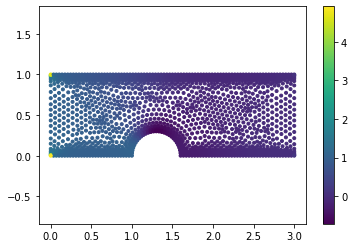

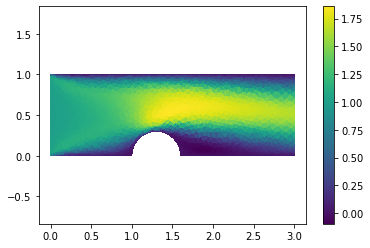

In [2]:
from user_fun.io import read_comsol
import matplotlib.pyplot as plt
import matplotlib.tri as tri

tb = read_comsol.comsol_read('half_cl.csv')
tb

plot_x = tb.values[:,0]
plot_y = tb.values[:,1]
plot_p = tb.values[:,2]
plot_u = tb.values[:,3]
plot_v = tb.values[:,4]
plot_input = tb.values[:,0:1]
plot_output = tb.values[:,2:4]
fig, ax = plt.subplots()
im = ax.scatter(plot_x, plot_y, marker= '.',c = plot_p, cmap='viridis')
cbar = ax.figure.colorbar(im, ax=ax)
ax.axis('equal')

fig, ax = plt.subplots()
triang = tri.Triangulation(plot_x, plot_y)

# Mask off unwanted triangles.
tri_centroid_x = plot_x[triang.triangles].mean(axis=1)
tri_centroid_y = plot_y[triang.triangles].mean(axis=1)
mask = np.hypot(tri_centroid_x-1.3,tri_centroid_y-0) < 0.3
triang.set_mask(mask )
cm = ax.tripcolor(triang, plot_u, cmap='viridis')

cbar = ax.figure.colorbar(cm, ax=ax)
ax.axis('equal')


pde_input = cloud_point_list[0][0]
from scipy.interpolate import griddata

def test_eval():
    plot_input,idx = np.unique(plot_input, axis=0,return_index=True)
    pde_output = griddata(plot_input, plot_p[idx], pde_input, method='cubic')
